In [4]:
!pip install -q torch

In [5]:
%%capture
import os
import torch
os.environ['TORCH'] = torch.__version__
os.environ['PYTHONWARNINGS'] = "ignore"
!pip install torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install git+https://github.com/pyg-team/pytorch_geometric.git

In [6]:
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures

dataset = Planetoid(root='data/Planetoid', name='Cora', transform=NormalizeFeatures())

print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.
print(data)

Processing...


Dataset: Cora():
Number of graphs: 1
Number of features: 1433
Number of classes: 7
Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])


Done!


In [9]:
from torch_geometric.nn import GCNConv
import torch.nn.functional as F

class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(42)
        self.conv1 = GCNConv(dataset.num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x

model = GCN(hidden_channels=16)
print(model)

GCN(
  (conv1): GCNConv(1433, 16)
  (conv2): GCNConv(16, 7)
)


In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()

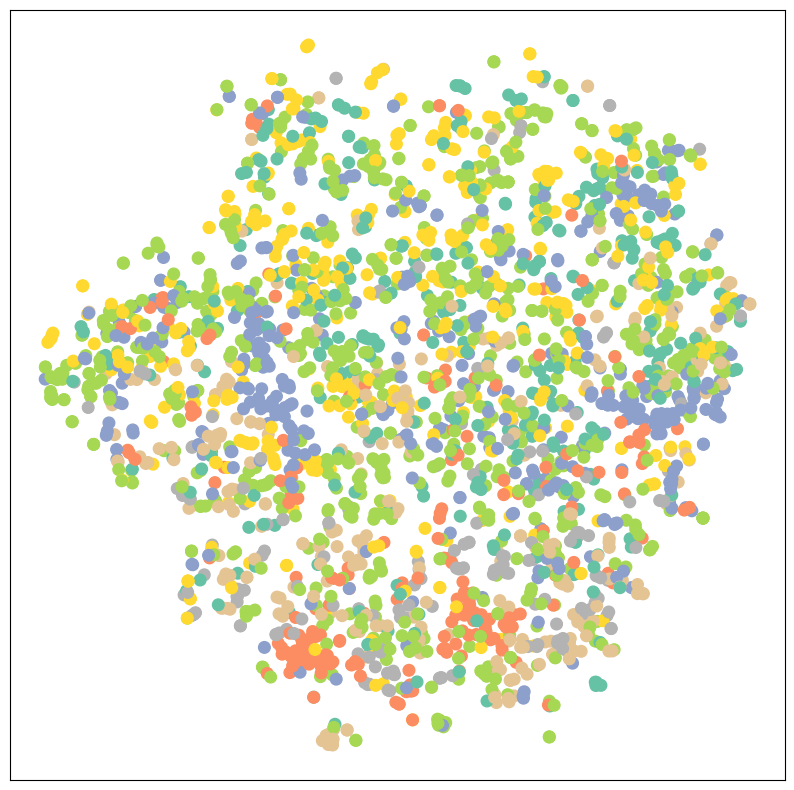

In [11]:
model.eval()

out = model(data.x, data.edge_index)
visualize(out, color=data.y)

Epoch: 001, Loss: 1.9457
Epoch: 002, Loss: 1.9414
Epoch: 003, Loss: 1.9340
Epoch: 004, Loss: 1.9248
Epoch: 005, Loss: 1.9121
Epoch: 006, Loss: 1.9059
Epoch: 007, Loss: 1.8949
Epoch: 008, Loss: 1.8827
Epoch: 009, Loss: 1.8717
Epoch: 010, Loss: 1.8614
Epoch: 011, Loss: 1.8517
Epoch: 012, Loss: 1.8296
Epoch: 013, Loss: 1.8275
Epoch: 014, Loss: 1.8078
Epoch: 015, Loss: 1.7991
Epoch: 016, Loss: 1.7840
Epoch: 017, Loss: 1.7628
Epoch: 018, Loss: 1.7484
Epoch: 019, Loss: 1.7325
Epoch: 020, Loss: 1.7170
Epoch: 021, Loss: 1.6988
Epoch: 022, Loss: 1.6884
Epoch: 023, Loss: 1.6784
Epoch: 024, Loss: 1.6547
Epoch: 025, Loss: 1.6187
Epoch: 026, Loss: 1.6123
Epoch: 027, Loss: 1.6032
Epoch: 028, Loss: 1.5843
Epoch: 029, Loss: 1.5617
Epoch: 030, Loss: 1.5547
Epoch: 031, Loss: 1.5179
Epoch: 032, Loss: 1.5030
Epoch: 033, Loss: 1.4777
Epoch: 034, Loss: 1.4568
Epoch: 035, Loss: 1.4447
Epoch: 036, Loss: 1.4375
Epoch: 037, Loss: 1.4218
Epoch: 038, Loss: 1.3863
Epoch: 039, Loss: 1.3499
Epoch: 040, Loss: 1.3455


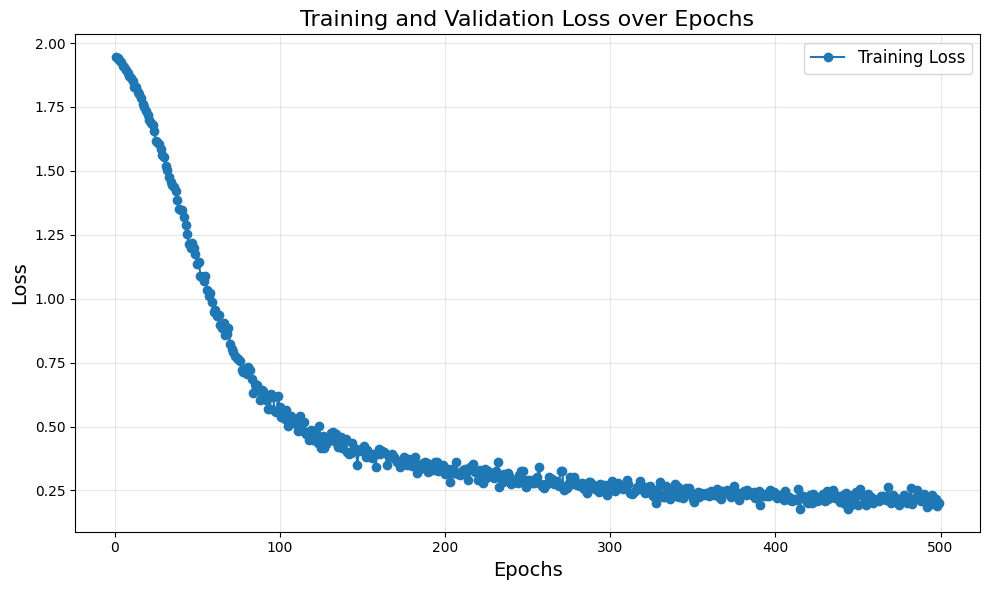

In [25]:
model = GCN(hidden_channels=16)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

def train():
      model.train()
      optimizer.zero_grad()
      out = model(data.x, data.edge_index)
      loss = criterion(out[data.train_mask], data.y[data.train_mask])
      loss.backward()
      optimizer.step()
      return loss

def test():
      model.eval()
      out = model(data.x, data.edge_index)
      pred = out.argmax(dim=1)
      test_correct = pred[data.test_mask] == data.y[data.test_mask]
      test_acc = int(test_correct.sum()) / int(data.test_mask.sum())
      return test_acc
epoch_count = []
train_loss = []

for epoch in range(1,500):
    loss = train()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')
    epoch_count.append(epoch)
    train_loss.append(loss.item())

# Plot the losses
plt.figure(figsize=(10, 6))
plt.plot(epoch_count, train_loss, label="Training Loss", marker='o')

# Customize the plot
plt.title("Training and Validation Loss over Epochs", fontsize=16)
plt.xlabel("Epochs", fontsize=14)
plt.ylabel("Loss", fontsize=14)
plt.legend(fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()

# Show the plot
plt.show()

In [26]:
test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.7940


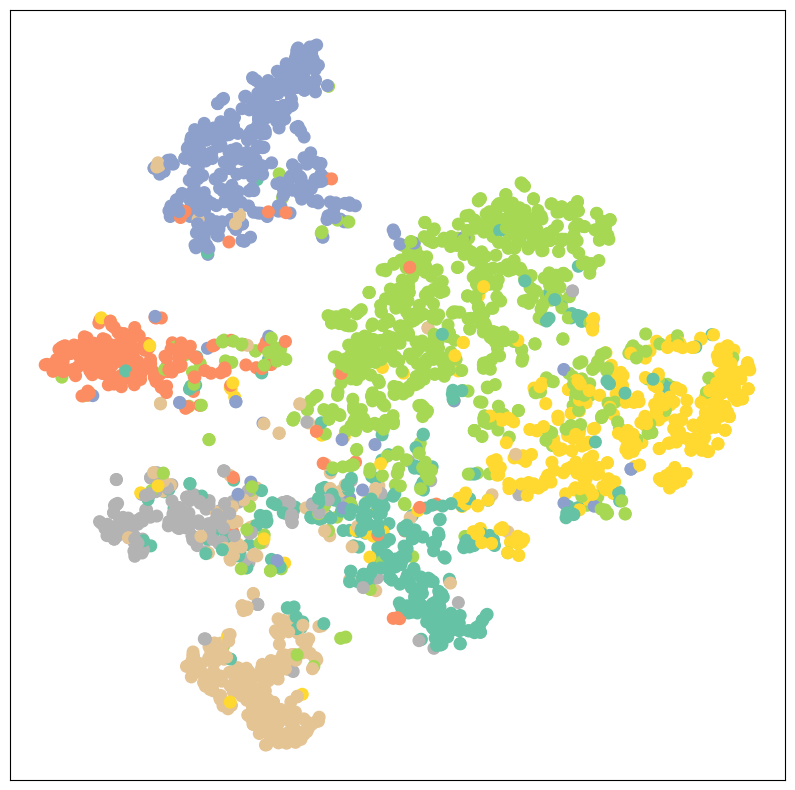

In [27]:
model.eval()
out = model(data.x, data.edge_index)
visualize(out, color=data.y)

GAT(
  (conv1): GATConv(1433, 8, heads=8)
  (conv2): GATConv(64, 7, heads=8)
)
Epoch: 001, Loss: 4.0245, Val: 0.3520, Test: 0.3770
Epoch: 002, Loss: 3.9926, Val: 0.4760, Test: 0.5240
Epoch: 003, Loss: 3.9555, Val: 0.5000, Test: 0.5560
Epoch: 004, Loss: 3.9104, Val: 0.5440, Test: 0.5740
Epoch: 005, Loss: 3.8645, Val: 0.5500, Test: 0.5870
Epoch: 006, Loss: 3.8111, Val: 0.5560, Test: 0.5800
Epoch: 007, Loss: 3.7478, Val: 0.5460, Test: 0.5730
Epoch: 008, Loss: 3.6821, Val: 0.5320, Test: 0.5650
Epoch: 009, Loss: 3.6151, Val: 0.5280, Test: 0.5610
Epoch: 010, Loss: 3.5253, Val: 0.5220, Test: 0.5570
Epoch: 011, Loss: 3.4305, Val: 0.5080, Test: 0.5490
Epoch: 012, Loss: 3.3468, Val: 0.5040, Test: 0.5430
Epoch: 013, Loss: 3.2313, Val: 0.4900, Test: 0.5280
Epoch: 014, Loss: 3.1400, Val: 0.4800, Test: 0.5180
Epoch: 015, Loss: 3.0162, Val: 0.4700, Test: 0.5080
Epoch: 016, Loss: 2.9145, Val: 0.4620, Test: 0.4990
Epoch: 017, Loss: 2.7860, Val: 0.4520, Test: 0.4940
Epoch: 018, Loss: 2.6948, Val: 0.4340

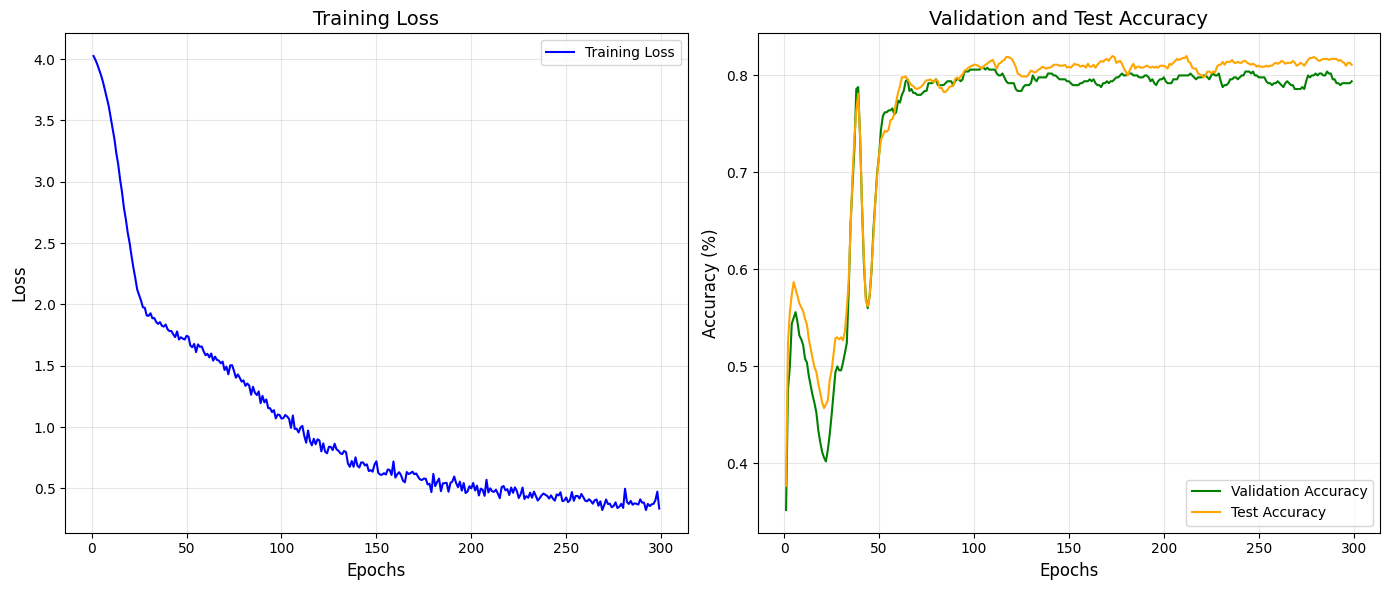

In [32]:
from torch_geometric.nn import GATConv

class GAT(torch.nn.Module):
    def __init__(self, hidden_channels, heads):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GATConv(dataset.num_features, hidden_channels,heads)
        self.conv2 = GATConv(heads*hidden_channels, dataset.num_classes,heads)

    def forward(self, x, edge_index):
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv2(x, edge_index)
        return x

model = GAT(hidden_channels=8, heads=8)
print(model)

optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

def train():
      model.train()
      optimizer.zero_grad()
      out = model(data.x, data.edge_index)
      loss = criterion(out[data.train_mask], data.y[data.train_mask])
      loss.backward()
      optimizer.step()
      return loss

def test(mask):
      model.eval()
      out = model(data.x, data.edge_index)
      pred = out.argmax(dim=1)
      correct = pred[mask] == data.y[mask]
      acc = int(correct.sum()) / int(mask.sum())
      return acc

epochs = []
val_acc_all = []
test_acc_all = []
train_loss = []

for epoch in range(1, 300):
    loss = train()
    val_acc = test(data.val_mask)
    test_acc = test(data.test_mask)
    val_acc_all.append(val_acc)
    test_acc_all.append(test_acc)
    train_loss.append(loss.item())
    epochs.append(epoch)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val: {val_acc:.4f}, Test: {test_acc:.4f}')

# Create subplots using plt.subplot()
plt.figure(figsize=(14, 6))

# Plot Training Loss (1st subplot)
plt.subplot(1, 2, 1)  # (rows, columns, index)
plt.plot(epochs, train_loss, label="Training Loss", color='blue')
plt.title("Training Loss", fontsize=14)
plt.xlabel("Epochs", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.grid(alpha=0.3)
plt.legend(fontsize=10)

# Plot Validation & Test Accuracy (2nd subplot)
plt.subplot(1, 2, 2)  # (rows, columns, index)
plt.plot(epochs, val_acc_all, label="Validation Accuracy", color='green')
plt.plot(epochs, test_acc_all, label="Test Accuracy", color='orange')
plt.title("Validation and Test Accuracy", fontsize=14)
plt.xlabel("Epochs", fontsize=12)
plt.ylabel("Accuracy (%)", fontsize=12)
plt.grid(alpha=0.3)
plt.legend(fontsize=10)

# Adjust layout and show
plt.tight_layout()
plt.show()

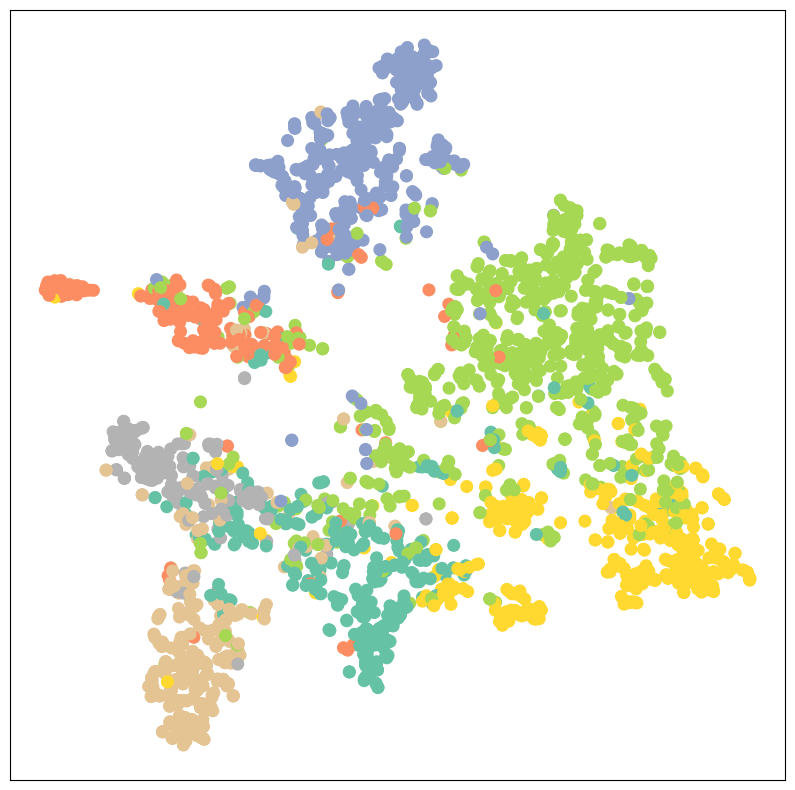

In [33]:
model.eval()

out = model(data.x, data.edge_index)
visualize(out, color=data.y)